<a href="https://colab.research.google.com/github/fellowship/platform-demos3/blob/master/InteriorDesignClassification/Google_Images_Data_Downloading_Cleaning_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating your own dataset from Google Images, Cleaning the dataset and Training a Model for Single Label Classification

## Download into file

Go to Google Images and search 'Bohemian Interior Design' and similarily for other classes. The more specific you are in your Google Search, the better the results and the less manual pruning you will have to do.

Scroll down until you've seen all the images you want to download, or until you see a button that says 'Show more results'. All the images you scrolled past are now available to download. To get more, click on the button, and continue scrolling. The maximum number of images Google Images shows is 700.

Now you must run some Javascript code in your browser which will save the URLs of all the images you want for you dataset.

Press CtrlShiftJ in Windows/Linux and CmdOptJ in Mac, and a small window the javascript 'Console' will appear. That is where you will paste the JavaScript commands.

You will need to get the urls of each of the images. You can do this by running the following commands:

`urls = Array.from(document.querySelectorAll('.rg_di .rg_meta')).map(el=>JSON.parse(el.textContent).ou);
window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));`

In [0]:
# Notebook magic commands
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *

In [3]:
#mount google drive in case we need to store data or transfer files
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Create directory and upload urls file into your server
Choose an appropriate name for your labeled images. 

In [0]:
classes = [
    'Bohemian',
    'Classic',
    'Coastal',
    'Eclectic',
    'Farmhouse',
    'Glam',
    'Global',
    'Industrial',
    'Midcentury',
    'Minimal',
    'Modern',
    'Preppy',
    'Rustic',
    'Scandinavian',
    'Traditional',
    'Transitional']

In [0]:
path = Path('data/interior_designs')
for folder in classes:
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)

In [0]:
path.ls()

[PosixPath('data/interior_designs/Eclectic'),
 PosixPath('data/interior_designs/Midcentury'),
 PosixPath('data/interior_designs/Coastal'),
 PosixPath('data/interior_designs/Scandinavian'),
 PosixPath('data/interior_designs/Global'),
 PosixPath('data/interior_designs/Industrial'),
 PosixPath('data/interior_designs/Glam'),
 PosixPath('data/interior_designs/Traditional'),
 PosixPath('data/interior_designs/Preppy'),
 PosixPath('data/interior_designs/Classic'),
 PosixPath('data/interior_designs/Minimal'),
 PosixPath('data/interior_designs/Modern'),
 PosixPath('data/interior_designs/Bohemian'),
 PosixPath('data/interior_designs/Transitional'),
 PosixPath('data/interior_designs/Farmhouse'),
 PosixPath('data/interior_designs/Rustic')]

In [0]:
import shutil
src = 'drive/My Drive/fellowship/Interior_Design/'
dst = 'data/interior_designs/'
for file in classes:
  shutil.copy2(src+file+'.csv', dst)

**Dowload 500 images per class**

In [0]:
for folder in classes:
  dest = path/folder
  file = folder+'.csv'
  download_images(path/file, dest, max_pics=500)

We can remove any images that can't be opened:



In [0]:
for c in classes:
  print(c)
  verify_images(path/c, delete=True, max_size=512)

## View data

In [0]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                  ds_tfms=get_transforms(max_warp=0., max_rotate=0.), 
                                  size=(224,224),num_workers=4).normalize(imagenet_stats)

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Bohemian',
  'Classic',
  'Coastal',
  'Eclectic',
  'Farmhouse',
  'Glam',
  'Global',
  'Industrial',
  'Midcentury',
  'Minimal',
  'Modern',
  'Preppy',
  'Rustic',
  'Scandinavian',
  'Traditional',
  'Transitional'],
 16,
 5682,
 1420)

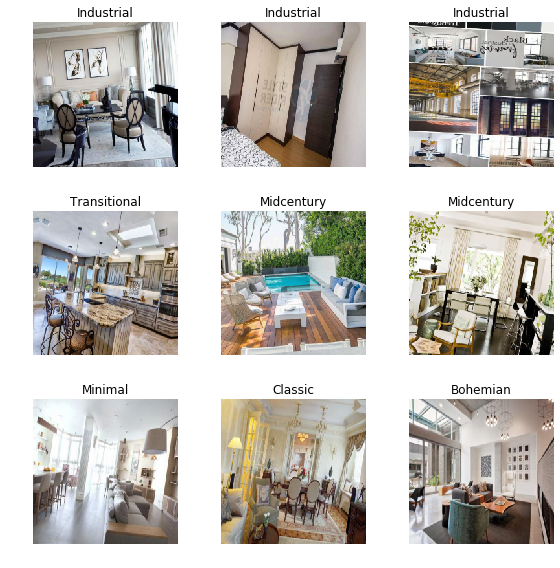

In [0]:
data.show_batch(rows=3, figsize=(8,8))

## Train model

Started with resnet18 for faster performance

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02


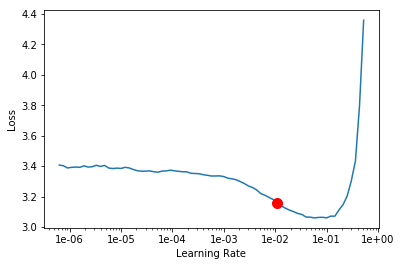

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(5, max_lr=1e-02)

In [0]:
learn.save('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06


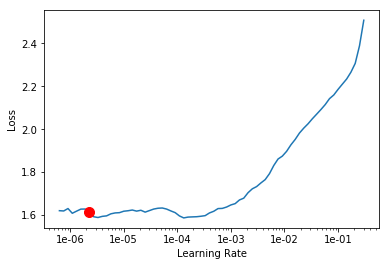

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

In [0]:
learn.save('stage-2')

In [0]:
!cp 'data/interior_designs/models/stage-2.pth' 'drive/My Drive/fellowship/Interior_Design/'

## Interpretation

In [0]:
learn.load('stage-2');
interp = ClassificationInterpretation.from_learner(learn)

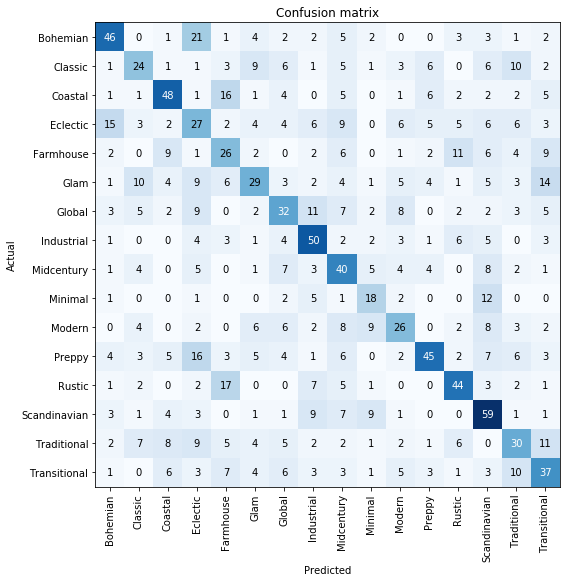

In [0]:
interp.plot_confusion_matrix(figsize=(8,8))

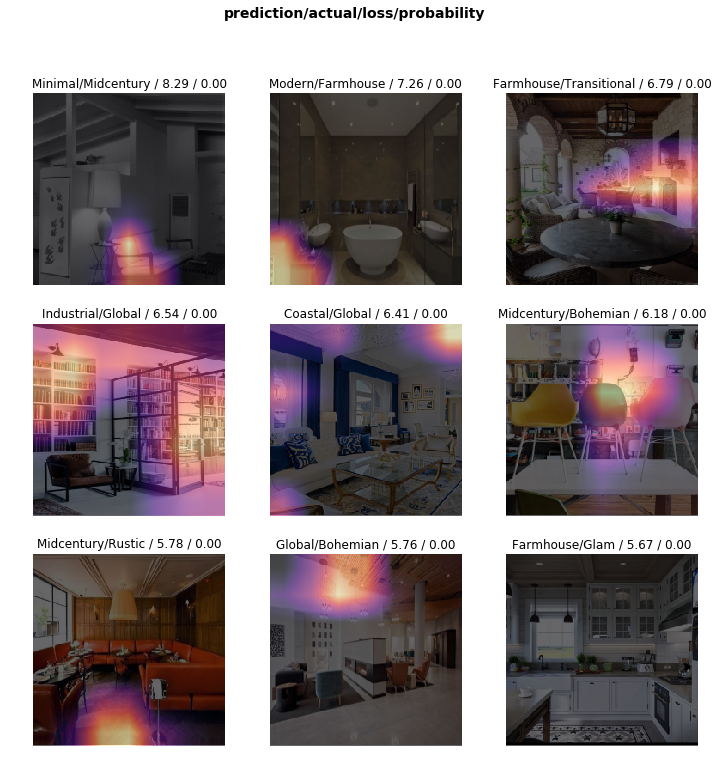

In [0]:
interp.plot_top_losses(9, figsize=(12,12))

## Cleaning Up - Manually
Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the ImageCleaner widget from fastai.widgets we can prune our top losses, removing photos that don't belong.

First we need to get the file paths from our top_losses. We can do this with .from_toplosses. We then feed the top losses indexes and corresponding dataset to ImageCleaner.

Notice that the widget will not delete images directly from disk but it will create a new csv file cleaned.csv from where you can create a new ImageDataBunch with the corrected labels to continue training your model.

In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the ds_type param which no longer has any effect.

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [0]:
learn_cln = cnn_learner(db, models.resnet18, metrics=error_rate)
learn_cln.load('stage-2')

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Let's remove top 10% images with highest loss and load rest in new csv file

In [0]:
paths=[]
labels=[]
for id in idxs[702:7102]:
  y = str(db.train_ds.x.items[id]).split('/')
  k = y[2]+"/"+y[3]
  paths.append(k)
  labels.append(db.train_ds.y.items[id])
d = {'Path':paths,'Label':labels}
df = pd.DataFrame(d)

In [0]:
lb = {
  0:'Bohemian',
  1:'Classic',
  2:'Coastal',
  3:'Eclectic',
  4:'Farmhouse',
  5:'Glam',
  6:'Global',
  7:'Industrial',
  8:'Midcentury',
  9:'Minimal',
  10:'Modern',
  11:'Preppy',
  12:'Rustic',
  13:'Scandinavian',
  14:'Traditional',
  15:'Transitional'}
df['Label'] = df['Label'].map(lb)
df.to_csv('data/interior_designs/cleaned.csv', index=False)

Deleted Manually as the widgets don't work on collab.

Remember to recreate your ImageDataBunch from your cleaned.csv to include the changes you made in your data!

In [0]:
df.head(10)

Path         Label
0    Midcentury/00000340.jpg    Midcentury
1  Transitional/00000181.jpg  Transitional
2      Eclectic/00000074.jpg      Eclectic
3    Industrial/00000256.jpg    Industrial
4   Traditional/00000409.jpg   Traditional
5        Rustic/00000283.jpg        Rustic
6        Preppy/00000409.jpg        Preppy
7      Bohemian/00000121.jpg      Bohemian
8    Farmhouse/00000431.jpeg     Farmhouse
9    Industrial/00000394.jpg    Industrial

## Create a final dataset of 6.4k images

In [0]:
os.mkdir('data/train_images')
path = Path('data/train_images')
for folder in classes:
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)

In [0]:
src = 'data/interior_designs/'
dst = 'data/train_images/'
for _path in df['Path']:
  shutil.copy2(src+_path, dst+_path)

In [0]:
for folders in classes:
  print(folders,len(get_image_files(dst+'/'+folders)))

Bohemian 392
Classic 464
Coastal 422
Eclectic 347
Farmhouse 382
Glam 436
Global 450
Industrial 352
Midcentury 337
Minimal 276
Modern 381
Preppy 442
Rustic 412
Scandinavian 450
Traditional 440
Transitional 417


In [0]:
# create a tarfile
import tarfile

def make_tarfile(output_filename, source_dir):
  with tarfile.open(output_filename, "w:gz") as tar:
    tar.add(source_dir, arcname=os.path.basename(source_dir))

In [0]:
make_tarfile('googled_interior.tar', dst)

In [0]:
!cp 'googled_interior.tar' 'drive/My Drive/fellowship/Interior_Design/'
!cp 'data/interior_designs/cleaned.csv' 'drive/My Drive/fellowship/Interior_Design/'

## Model Training on Cleaned Dataset

In [0]:
# copy the csv file for labels and the dataset folder
import os
os.mkdir('data/')
!cp "drive/My Drive/fellowship/Interior_Design/googled_interior.tar" "."

In [5]:
# Untar the tar file
!tar -zxf googled_interior.tar -C data/

tar: Removing leading `/' from member names


In [0]:
np.random.seed(42)
path = Path('data/')

data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  size=(224,224), num_workers=4).normalize(imagenet_stats)

In [7]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Bohemian',
  'Classic',
  'Coastal',
  'Eclectic',
  'Farmhouse',
  'Glam',
  'Global',
  'Industrial',
  'Midcentury',
  'Minimal',
  'Modern',
  'Preppy',
  'Rustic',
  'Scandinavian',
  'Traditional',
  'Transitional'],
 16,
 5120,
 1280)

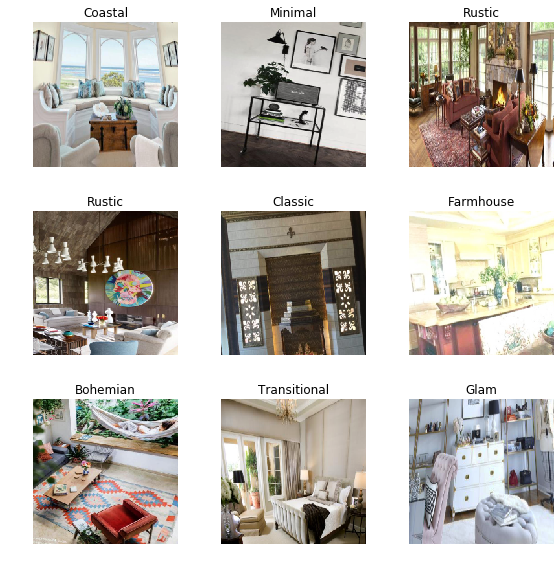

In [8]:
data.show_batch(rows=3, figsize=(8,8))

In [9]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 152948018.93it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-02


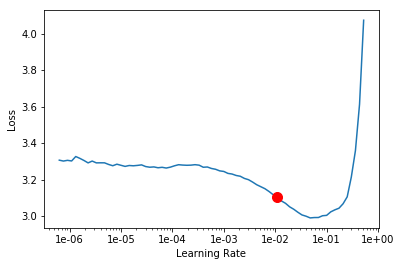

In [0]:
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

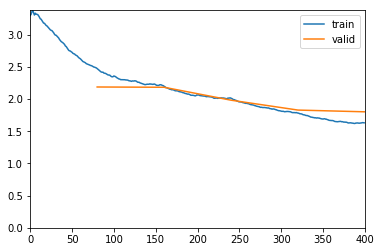

Better model found at epoch 0 with accuracy value: 0.30390626192092896.
Better model found at epoch 1 with accuracy value: 0.32343751192092896.
Better model found at epoch 2 with accuracy value: 0.37187498807907104.
Better model found at epoch 3 with accuracy value: 0.42265623807907104.
Better model found at epoch 4 with accuracy value: 0.4429687559604645.


In [0]:
from fastai.callbacks import *
learn.fit_one_cycle(5, max_lr=1e-02, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy', name='Stage1-1')])

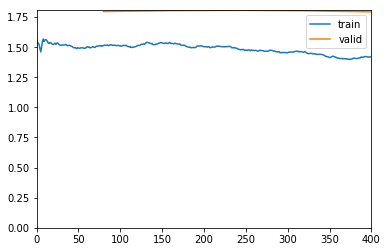

Better model found at epoch 0 with accuracy value: 0.4429687559604645.
Better model found at epoch 2 with accuracy value: 0.44609373807907104.


In [0]:
learn.load('Stage1-1')
learn.fit_one_cycle(5, max_lr=1e-03, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy', name='Stage1-2')])

**Finetuning**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


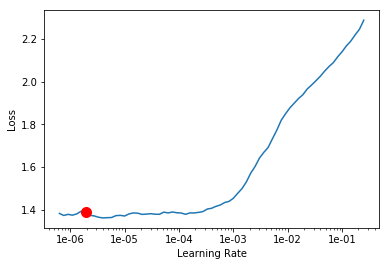

In [13]:
learn.load('Stage1-2')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

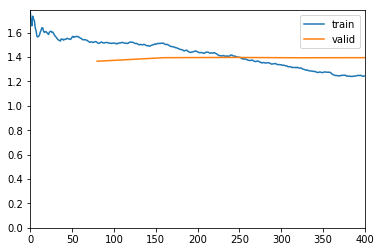

Better model found at epoch 0 with accuracy value: 0.5625.
Better model found at epoch 1 with accuracy value: 0.5687500238418579.


In [12]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy', name='Stage1-3')])

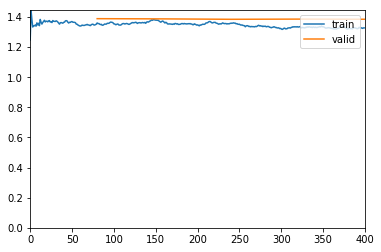

Better model found at epoch 0 with accuracy value: 0.5703125.


In [15]:
learn.load('Stage1-3')
learn.unfreeze()
learn.fit_one_cycle(5, max_lr=slice(1e-6,1e-5), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy', name='Stage1-4')])

## Interpretation for Cleaned Dataset

In [0]:
learn.load('Stage1-4');
interp = ClassificationInterpretation.from_learner(learn)

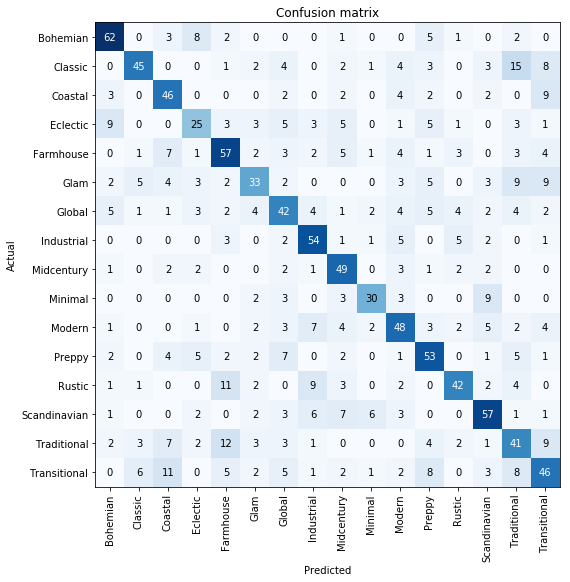

In [32]:
interp.plot_confusion_matrix(figsize=(8,8))

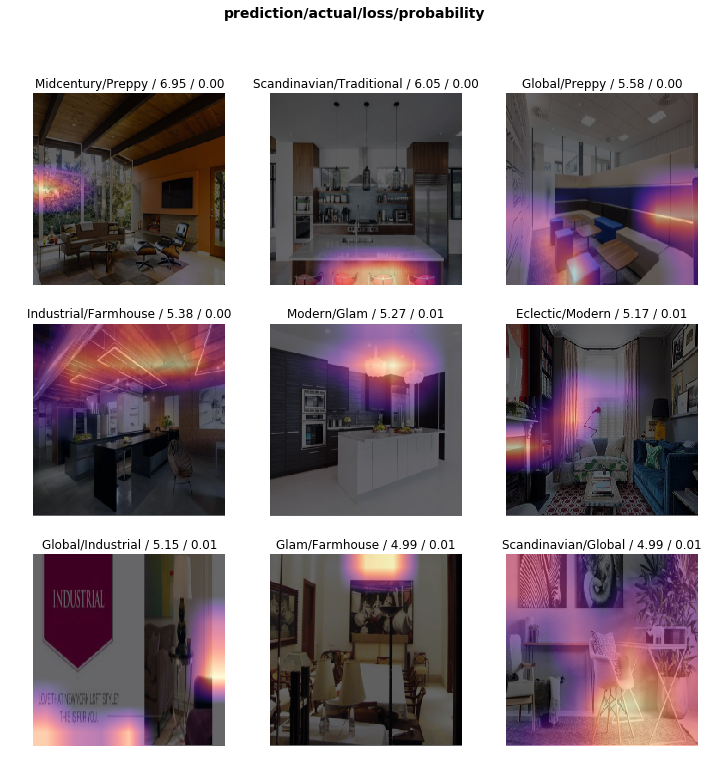

In [31]:
interp.plot_top_losses(9, figsize=(12,12))

## Refine it further

In [0]:
from fastai.widgets import *

In [0]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('Stage1-4')

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Let's remove top 10% images with highest loss and load rest in new csv file

In [0]:
paths=[]
labels=[]
for id in idxs[640:6400]:
  y = str(db.train_ds.x.items[id]).split('/')
  k = y[1]+"/"+y[2]
  paths.append(k)
  labels.append(db.train_ds.y.items[id])
d = {'Path':paths,'Label':labels}
df = pd.DataFrame(d)

In [0]:
lb = {
  0:'Bohemian',
  1:'Classic',
  2:'Coastal',
  3:'Eclectic',
  4:'Farmhouse',
  5:'Glam',
  6:'Global',
  7:'Industrial',
  8:'Midcentury',
  9:'Minimal',
  10:'Modern',
  11:'Preppy',
  12:'Rustic',
  13:'Scandinavian',
  14:'Traditional',
  15:'Transitional'}
df['Label'] = df['Label'].map(lb)
df.to_csv('cleaned.csv', index=False)

In [41]:
df.head()

Path         Label
0  Transitional/00000023.jpg  Transitional
1    Midcentury/00000018.jpg    Midcentury
2    Industrial/00000072.jpg    Industrial
3      Eclectic/00000074.jpg      Eclectic
4      Eclectic/00000385.jpg      Eclectic

## Create a final cleaner dataset of 5760 images

In [0]:
#os.mkdir('train_images')
path = Path('train_images')
for folder in classes:
  dest = path/folder
  dest.mkdir(parents=True, exist_ok=True)

In [0]:
src = 'data/'
dst = 'train_images/'
for _path in df['Path']:
  shutil.copy2(src+_path, dst+_path)

In [47]:
for folders in classes:
  print(folders,len(get_image_files(dst+'/'+folders)))

Bohemian 296
Classic 464
Coastal 417
Eclectic 132
Farmhouse 365
Glam 433
Global 447
Industrial 227
Midcentury 180
Minimal 276
Modern 380
Preppy 435
Rustic 409
Scandinavian 450
Traditional 435
Transitional 414


In [0]:
# create a tarfile
import tarfile

def make_tarfile(output_filename, source_dir):
  with tarfile.open(output_filename, "w:gz") as tar:
    tar.add(source_dir, arcname=os.path.basename(source_dir))

In [0]:
make_tarfile('refined_interior.tar', dst)

In [0]:
!cp 'refined_interior.tar' 'drive/My Drive/fellowship/Interior_Design/'
!cp 'cleaned.csv' 'drive/My Drive/fellowship/Interior_Design/'

## Model Training on Refined Dataset

In [0]:
np.random.seed(42)
path = Path('train_images/')

data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  size=(224,224), num_workers=4).normalize(imagenet_stats)

In [52]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Bohemian',
  'Classic',
  'Coastal',
  'Eclectic',
  'Farmhouse',
  'Glam',
  'Global',
  'Industrial',
  'Midcentury',
  'Minimal',
  'Modern',
  'Preppy',
  'Rustic',
  'Scandinavian',
  'Traditional',
  'Transitional'],
 16,
 4608,
 1152)

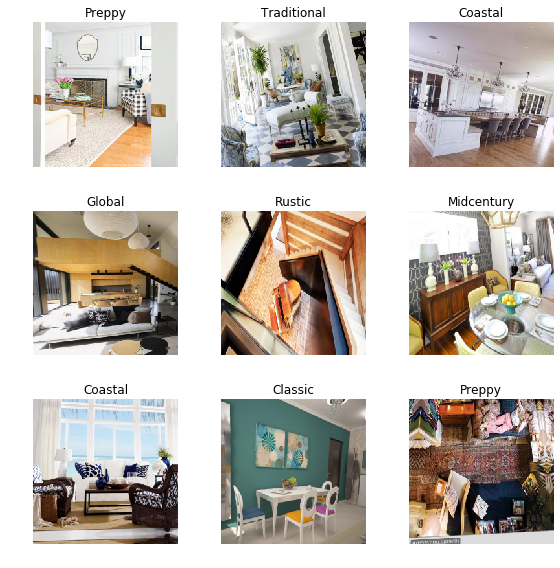

In [53]:
data.show_batch(rows=3, figsize=(8,8))

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

In [0]:
!cp 'data/models/Stage1-4.pth' 'train_images/models/'

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-05


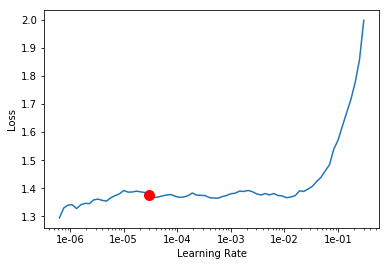

In [64]:
learn.load('Stage1-4')
learn.freeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

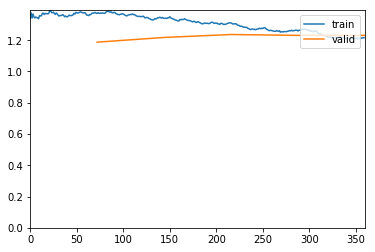

Better model found at epoch 0 with accuracy value: 0.6284722089767456.


In [65]:
learn.fit_one_cycle(5, max_lr=1e-03, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy', name='Stage1-1')])

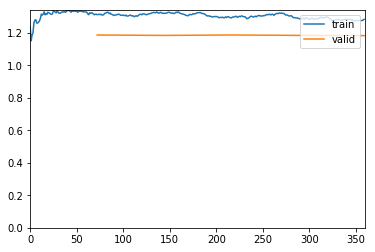

Better model found at epoch 0 with accuracy value: 0.6258680820465088.
Better model found at epoch 1 with accuracy value: 0.6328125.


In [66]:
learn.load('Stage1-1')
learn.fit_one_cycle(5, max_lr=1e-04, callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy', name='Stage1-2')])

**Fine Tuning**

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07


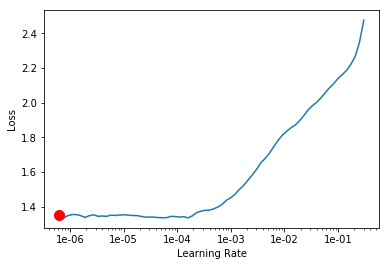

In [58]:
learn.load('Stage1-2')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

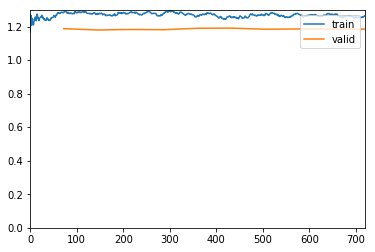

Better model found at epoch 0 with accuracy value: 0.6258680820465088.
Better model found at epoch 1 with accuracy value: 0.6267361044883728.


In [68]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,1e-4), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy', name='Stage1-3')])

**progressive resizing**

In [0]:
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
                                  ds_tfms=get_transforms(), 
                                  size=(256,256), num_workers=4).normalize(imagenet_stats)

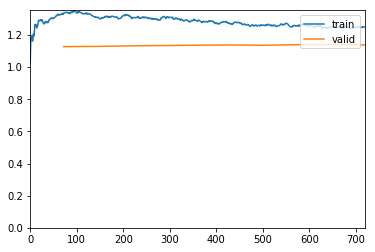

Better model found at epoch 0 with accuracy value: 0.6388888955116272.


In [74]:
learn.load('Stage1-2')
learn.data = data
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-5), callbacks=[ShowGraph(learn), SaveModelCallback(learn, mode='max', every='improvement', monitor='accuracy', name='Stage1-3')])

## Prediction on Test images (On Deepdesign.space images)
First thing first, let's export the content of our Learner object for production:

In [0]:
learn.load('Stage1-3')
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [79]:
!pip install wget

  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


**Testing on Bohemian Interior Design Image**

In [80]:
import wget
!wget https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Bohemian/image_Bohemian_interior_design_5.png

--2019-06-13 16:56:27--  https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Bohemian/image_Bohemian_interior_design_5.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 135024 (132K) [image/png]
Saving to: ‘image_Bohemian_interior_design_5.png’

image_Bohemian_inte 100%[===================>] 131.86K  --.-KB/s    in 0.002s  

2019-06-13 16:56:27 (56.9 MB/s) - ‘image_Bohemian_interior_design_5.png’ saved [135024/135024]



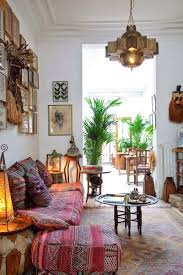

In [85]:
defaults.device = torch.device('cpu')
img1 = open_image('image_Bohemian_interior_design_5.png')
img1

We create our Learner in production enviromnent like this, just make sure that path contains the file 'export.pkl' from before.



In [86]:
learn = load_learner(path)
pred_class,pred_idx,outputs = learn.predict(img1)
pred_class

Category Bohemian

**Testing on Coastal Interior Design Image**

In [87]:
!wget https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Coastal/007d04bd1fcd13a3aedbf343549fe18e.jpg

--2019-06-13 16:59:43--  https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Coastal/007d04bd1fcd13a3aedbf343549fe18e.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47394 (46K) [image/jpeg]
Saving to: ‘007d04bd1fcd13a3aedbf343549fe18e.jpg’

007d04bd1fcd13a3aed 100%[===================>]  46.28K  --.-KB/s    in 0.001s  

2019-06-13 16:59:43 (60.1 MB/s) - ‘007d04bd1fcd13a3aedbf343549fe18e.jpg’ saved [47394/47394]



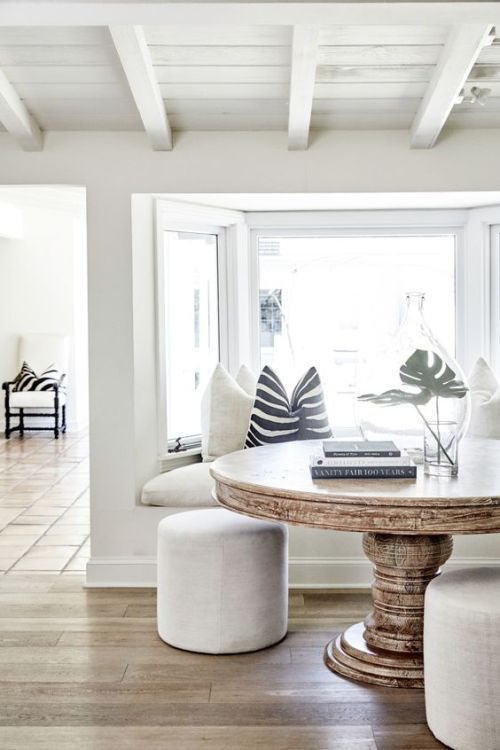

In [88]:
img2 = open_image('007d04bd1fcd13a3aedbf343549fe18e.jpg')
img2

In [90]:
pred_class,pred_idx,outputs = learn.predict(img2)
pred_class

Category Coastal

**Testing on Scandinavian Interior Design Image**

In [91]:
!wget https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Scandinavian/image_scandinavian_interior_design_21.png

--2019-06-13 17:02:30--  https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Scandinavian/image_scandinavian_interior_design_21.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 57633 (56K) [image/png]
Saving to: ‘image_scandinavian_interior_design_21.png’

image_scandinavian_ 100%[===================>]  56.28K  --.-KB/s    in 0.001s  

2019-06-13 17:02:30 (38.6 MB/s) - ‘image_scandinavian_interior_design_21.png’ saved [57633/57633]



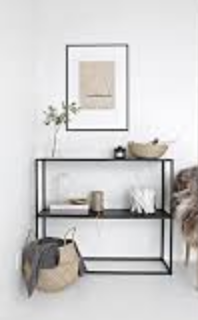

In [92]:
img3 = open_image('image_scandinavian_interior_design_21.png')
img3

In [93]:
pred_class,pred_idx,outputs = learn.predict(img3)
pred_class

Category Scandinavian

**Testing on Industrial Interior Design Image**

In [94]:
!wget https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Industrial/image_industrial_design_living_room_66.png

--2019-06-13 17:03:37--  https://raw.githubusercontent.com/YichenQiu/deepdesign.space/master/Image_data/Industrial/image_industrial_design_living_room_66.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519573 (507K) [image/png]
Saving to: ‘image_industrial_design_living_room_66.png’

image_industrial_de 100%[===================>] 507.40K  --.-KB/s    in 0.006s  

2019-06-13 17:03:38 (76.8 MB/s) - ‘image_industrial_design_living_room_66.png’ saved [519573/519573]



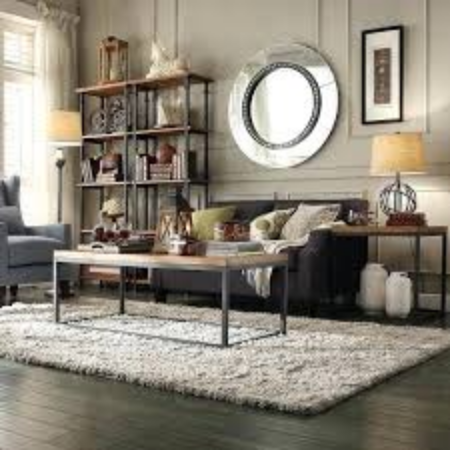

In [95]:
img4 = open_image('image_industrial_design_living_room_66.png')
img4

In [97]:
pred_class,pred_idx,outputs = learn.predict(img4)
pred_class

Category Industrial

**Amazingly got 100% correct predictions results**